# Librerías

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Conexión al repositorio de datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lectura de dataset

In [3]:
#Cargaremos un dataset de ventas
#Este dataset contiene las ventas mensuales de una cadena de tiendas
df = pd.read_csv('/content/drive/MyDrive/Data/ventas.csv')
df

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083
...,...,...,...
308,Sep-2016,45528702,44534797
309,Oct-2016,44770113,45061618
310,Nov-2016,46285062,45141762
311,Dec-2016,50016137,44943929


### Negocio podría pedirnos cuale serán las ventas de Feb, Mar, Apr del 2017.

In [ ]:


#Si consultamos los datos, veremos los siguientes campos
# Adjustments: Año y mes de las ventas
# Unadjusted: Valor de las ventas en dólares realizadas en el mes
# Seasonally adjusted: Valor de las ventas en dólares realizadas en el mes, según un modelo de regresión simple
df.dtypes

Adjustments            object
Unadjusted              int64
Seasonally adjusted     int64
dtype: object

### El campo Adjustment dice que es un objeto, hay que castearlo, porque necesitamos un dato con temporalidad.

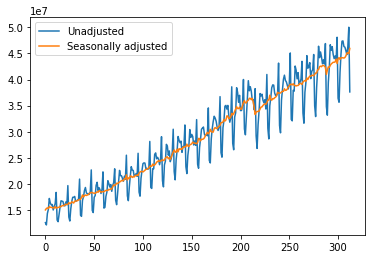

In [ ]:

#Vamos a graficarlo
#En azul son la evolución de ventas mensuales
#En naranaja la evolución de las ventas mensuales según un modelo de regresión linea
#Vemos que los datos que entrega el modelo no son iguales a la realidad
#Vamos a construir un modelo de Deep Learning que represente mejor esta realidad
df.plot()

# Feature Engineering para series temporales

In [ ]:
#Primero adaptamos nuestro dataset para que lo pueda procesar una red recurrente

In [4]:
#Vamos a cambiar los nombres de los campos por nombres más intuitivos
df1 = df.rename(columns = {
  'Adjustments': 'Mes', 
  'Unadjusted': 'Monto', 
  'Seasonally adjusted': 'Monto_Aprox'
})

df1

,Mes,Monto,Monto_Aprox
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083
...,...,...,...
308,Sep-2016,45528702,44534797
309,Oct-2016,44770113,45061618
310,Nov-2016,46285062,45141762
311,Dec-2016,50016137,44943929


In [5]:
#Vamos a seleccionar los campos que nos interesan
# En este caso se quiere analizar la tendencia, por lo que solo se ocupan dos campos, la temporalidad, y el campo valor del que vamos a obtener su evolución.
df2 = df1[['Mes', 'Monto']]
df2

,Mes,Monto
0,Jan-1991,12588862
1,Feb-1991,12154321
2,Mar-1991,14337072
3,Apr-1991,15108570
4,May-1991,17225734
...,...,...
308,Sep-2016,45528702
309,Oct-2016,44770113
310,Nov-2016,46285062
311,Dec-2016,50016137


In [ ]:
#Revisemos los tipos de datos
#Notamos que "Mes" es un "object"
#Es necesario colocarlo como un tipo de dato fecha
df2.dtypes

Mes      object
Monto     int64
dtype: object

In [7]:
#Creamos un nuevo campo llamado "Fecha" formateando el campo "Mes"
df2['Fecha'] = pd.to_datetime(df2['Mes'], format='%b-%Y', errors = 'ignore')
df2

,Mes,Monto,Fecha
0,Jan-1991,12588862,1991-01-01
1,Feb-1991,12154321,1991-02-01
2,Mar-1991,14337072,1991-03-01
3,Apr-1991,15108570,1991-04-01
4,May-1991,17225734,1991-05-01
...,...,...,...
308,Sep-2016,45528702,2016-09-01
309,Oct-2016,44770113,2016-10-01
310,Nov-2016,46285062,2016-11-01
311,Dec-2016,50016137,2016-12-01


In [8]:
#Si consultamos los tipos de datos notamos que fecha es un tipo "datetime"
df2.dtypes

Mes              object
Monto             int64
Fecha    datetime64[ns]
dtype: object

In [9]:
#Puedes conocer más de otros formatos de fechas en el siguiente enlace
#https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

In [10]:
#Eliminamos el campo "Mes"
del df2['Mes']

In [11]:
#Si consultamos, solo tenemos dos campos, la fecha (que representa la estacionalidad) y el monto de ventas
#También notemos que como ahora el campo "Fecha" es un "date" le ha agregado el primer día del mes a cada mes
df2

,Monto,Fecha
0,12588862,1991-01-01
1,12154321,1991-02-01
2,14337072,1991-03-01
3,15108570,1991-04-01
4,17225734,1991-05-01
...,...,...
308,45528702,2016-09-01
309,44770113,2016-10-01
310,46285062,2016-11-01
311,50016137,2016-12-01


### Tenemos un potencial problema, pero es funcional de negocio, las fechas están al 01 de cada mes.
### Alguien que no conozca puede mal interpretar esa fecha.

In [13]:
#Como las ventas representan los montos recaudados al final del mes, deberemos colocar el último día del mes
#Utilizaremos la función utilitaria MonthEnd que nos retorna el día del último mes para cada mes, (enero: 31, febrero: 28 ó 29 según el año, marzo: 31, ...)
from pandas.tseries.offsets import MonthEnd

In [14]:
#Agregamos el último día del mes a todas las fechas
df2['Fecha'] = df2['Fecha'] + MonthEnd(1)
df2

,Monto,Fecha
0,12588862,1991-01-31
1,12154321,1991-02-28
2,14337072,1991-03-31
3,15108570,1991-04-30
4,17225734,1991-05-31
...,...,...
308,45528702,2016-09-30
309,44770113,2016-10-31
310,46285062,2016-11-30
311,50016137,2016-12-31


In [15]:
#Ahora ordenamos el dataframe en función del campo fecha, de menor a mayor
df3 = df2.sort_values('Fecha')
df3

,Monto,Fecha
0,12588862,1991-01-31
1,12154321,1991-02-28
2,14337072,1991-03-31
3,15108570,1991-04-30
4,17225734,1991-05-31
...,...,...
308,45528702,2016-09-30
309,44770113,2016-10-31
310,46285062,2016-11-30
311,50016137,2016-12-31


####Ya tenemos los campos con los que se trabajarán bien formateados, Fecha que representa la temporalidad y Monto que es el valor.

###### *Pero una red recurrente solo analiza un valor o sea solo un campo, la temporalidad debe estar en el indice.*

# Indexando el dataframe

In [ ]:
#En este momento el dataframe está indexado por los índices
#Por ejemplo, si queremos obtener el primer elemento, consultamos por el índice 0
df3.iloc[0]

Monto               12588862
Fecha    1991-01-31 00:00:00
Name: 0, dtype: object

In [ ]:
#Nos convendrá indexar el dataframe por la fecha para poder navegar por la fecha en lugar del índice y poder hacer lo siguiente
#df3.iloc['1991-01-31']

In [16]:
# Tenemos que redefinir el indice.
#Reasignamos al campo fecha como índice del dataframe. Campo de la temporalidad
df3 = df3.set_index('Fecha')
df3

,Monto
Fecha,
1991-01-31,12588862
1991-02-28,12154321
1991-03-31,14337072
1991-04-30,15108570
1991-05-31,17225734
...,...
2016-09-30,45528702
2016-10-31,44770113
2016-11-30,46285062


In [17]:
#Notemos que ha desaparecido como campo
df3.dtypes

Monto    int64
dtype: object

In [18]:
#Esto es porque ahora forma parte de los índices del dataframe
#Si queremos consultar por un índice que no es el regular, deberemos hacerlo con la función "loc"
df3.loc['1991-01-31']

Monto    12588862
Name: 1991-01-31 00:00:00, dtype: int64

In [19]:
#Con esta estructura ya tenemos todo listo para dividir los datos en validación y entrenamiento
df3

,Monto
Fecha,
1991-01-31,12588862
1991-02-28,12154321
1991-03-31,14337072
1991-04-30,15108570
1991-05-31,17225734
...,...
2016-09-30,45528702
2016-10-31,44770113
2016-11-30,46285062


# División en datos de entrenamiento y validación

In [20]:
#Para realizar el corte, tenemos que tener los datos ordenados e indicar hasta que fecha se usará la data para entrenar
#Debemos definir la fecha como un tipo date
fecha_entrenar = pd.Timestamp('2011-01-01')
fecha_entrenar

Timestamp('2011-01-01 00:00:00')

In [21]:
#Hacemos el corte para entrenar, el loc[desde:hasta], si se deja en blanco antes de los dos puntos va desde el inicio hasta el indicado depsues de los : puntos.
dfTrain = df3.loc[:fecha_entrenar]
dfTrain

,Monto
Fecha,
1991-01-31,12588862
1991-02-28,12154321
1991-03-31,14337072
1991-04-30,15108570
1991-05-31,17225734
...,...
2010-08-31,37395330
2010-09-30,36923390
2010-10-31,37014326


In [22]:
#Verificamos cuántos datos tenemos para entrenar
dfTrain.size

240

In [23]:
#Hacemos el corte para validar
dfTest = df3.loc[fecha_entrenar:]
dfTest

,Monto
Fecha,
2011-01-31,31191594
2011-02-28,29797949
2011-03-31,36099866
2011-04-30,38035760
2011-05-31,40046516
...,...
2016-09-30,45528702
2016-10-31,44770113
2016-11-30,46285062


In [24]:
#Verificamos cuántos datos tenemos para validar
dfTest.size

73

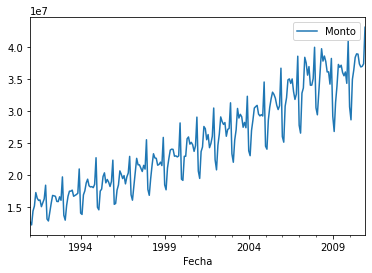

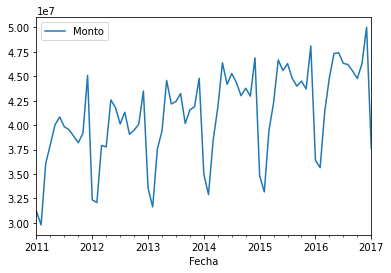

In [29]:
## Asi se pinta en dos gráficos diferentes, lo que no nos sirve.

dfTrain.plot()
dfTest.plot()

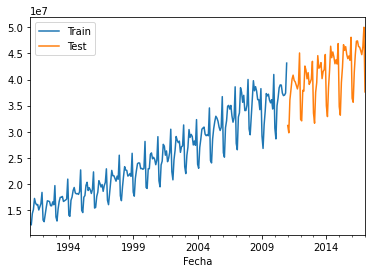

In [30]:
#Graficamos los datos de entrenamiento y validación

#Graficamos la data de entrenamiento y obtenemos el cuadro en donde se dibujo
ejes = dfTrain.plot()

#Usamos estos ejes para agregar y dibujar la data de validación
dfTest.plot(ax = ejes)

#Agregamos una leyenda
plt.legend(['Train', 'Test'])

In [31]:
#Finalmente, escalamos los datos
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [32]:
train = sc.fit_transform(dfTrain)
train

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795],
       [0.16362761],
       [0.13514108],
       [0.12395846],
       [0.12617398],
       [0.09230917],
       [0.11139526],
       [0.13173822],
       [0.20091289],
       [0.03002688],
       [0.01999285],
       [0.06596369],
       [0.10983126],
       [0.14912986],
       [0.14718865],
       [0.14464787],
       [0.11898427],
       [0.11802682],
       [0.14222108],
       [0.12459168],
       [0.24290801],
       [0.04899091],
       [0.02408276],
       [0.09865054],
       [0.14480155],
       [0.17061844],
       [0.17067229],
       [0.17603636],
       [0.1449117 ],
       [0.14957943],
       [0.15381982],
       [0.16036484],
       [0.28308682],
       [0.05971347],
       [0.05306762],
       [0.15199345],
       [0.17230214],
       [0.21246911],
       [0.23131079],
       [0.1982186 ],
       [0.19187716],
       [0.19381714],
       [0.18857277],
       [0.20528237],
       [0.339

#### No necesitamos hacer el fit porque usamos la misma escala de valores, anterior, por eso se usa directo el transform.

In [33]:
test = sc.transform(dfTest)
test

array([[0.61423187],
       [0.56926634],
       [0.77259579],
       [0.83505683],
       [0.89993326],
       [0.92552046],
       [0.89302107],
       [0.88363094],
       [0.86220767],
       [0.84048091],
       [0.87180554],
       [1.06265011],
       [0.65198848],
       [0.6431242 ],
       [0.83176496],
       [0.82666946],
       [0.98182284],
       [0.95616179],
       [0.90265615],
       [0.94107108],
       [0.86841056],
       [0.88189991],
       [0.90152769],
       [1.01100691],
       [0.69112114],
       [0.6285977 ],
       [0.81975104],
       [0.8791154 ],
       [1.04612377],
       [0.96841925],
       [0.97644296],
       [1.00288811],
       [0.90392615],
       [0.94879721],
       [0.95953255],
       [1.05319955],
       [0.7364742 ],
       [0.66953725],
       [0.84874774],
       [0.95681131],
       [1.10426647],
       [1.03325855],
       [1.06896205],
       [1.03909791],
       [0.9957921 ],
       [1.0202471 ],
       [0.99420458],
       [1.120

# Definición de features y labels

In [ ]:
#En este caso, los features y labels son especiales, tenemos estos datos en nuestro dataframe
dfTrain

,Monto
Fecha,
1991-01-31,12588862
1991-02-28,12154321
1991-03-31,14337072
1991-04-30,15108570
1991-05-31,17225734
...,...
2010-08-31,37395330
2010-09-30,36923390
2010-10-31,37014326


In [ ]:
#Por ejemplo para la fecha:
#
# 1991-01-31	(Enero 1991), el valor de "x" será las ventas de ese mes y el valor de "y" las ventas del siguiente mes (Febrero 1991)
# 1991-02-28	(Febrero 1991), el valor de "x" será las ventas de ese mes y el valor de "y" las ventas del siguiente mes (Marzo 1991)
# 1991-03-31	(Marzo 1991), el valor de "x" será las ventas de ese mes y el valor de "y" las ventas del siguiente mes (Abril 1991)
#
#Deberemos tener una estructura de este tipo:
#
# Fecha           Monto     MontoMesSiguiente
# 1991-01-31      12588862     12154321
# 1991-02-28      12154321     14337072
# 1991-03-31      14337072     15108570
# ...
# 2010-10-31      37014326     37408825
# 2010-11-30      37408825     43147947
# 2010-12-31      43147947     None
#
#Notemos que en la última fecha, ya no tenemos un mes siguiente, así que ese último dato lo deberemos ignorar

Se va a realizar con un vector, aunque lo más recomendado es hacerlo con los dataframe, luego se hara otro ejemplo.

In [36]:
#Definimos el valor de "x_train"
#Seleccionamos todo, menos el último elemento, porque el último no se va a asignar.
x_train = train[:-1]
x_train

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795],
       [0.16362761],
       [0.13514108],
       [0.12395846],
       [0.12617398],
       [0.09230917],
       [0.11139526],
       [0.13173822],
       [0.20091289],
       [0.03002688],
       [0.01999285],
       [0.06596369],
       [0.10983126],
       [0.14912986],
       [0.14718865],
       [0.14464787],
       [0.11898427],
       [0.11802682],
       [0.14222108],
       [0.12459168],
       [0.24290801],
       [0.04899091],
       [0.02408276],
       [0.09865054],
       [0.14480155],
       [0.17061844],
       [0.17067229],
       [0.17603636],
       [0.1449117 ],
       [0.14957943],
       [0.15381982],
       [0.16036484],
       [0.28308682],
       [0.05971347],
       [0.05306762],
       [0.15199345],
       [0.17230214],
       [0.21246911],
       [0.23131079],
       [0.1982186 ],
       [0.19187716],
       [0.19381714],
       [0.18857277],
       [0.20528237],
       [0.339

In [37]:
#Consultamos el tamaño
x_train.size

239

In [38]:
#Definimos el valor de "y_train"
#Seleccionamos desde el elemento de posición 1, ignoramos la posición 0.
y_train = train[1:]
y_train

array([[0.        ],
       [0.0704258 ],
       [0.09531795],
       [0.16362761],
       [0.13514108],
       [0.12395846],
       [0.12617398],
       [0.09230917],
       [0.11139526],
       [0.13173822],
       [0.20091289],
       [0.03002688],
       [0.01999285],
       [0.06596369],
       [0.10983126],
       [0.14912986],
       [0.14718865],
       [0.14464787],
       [0.11898427],
       [0.11802682],
       [0.14222108],
       [0.12459168],
       [0.24290801],
       [0.04899091],
       [0.02408276],
       [0.09865054],
       [0.14480155],
       [0.17061844],
       [0.17067229],
       [0.17603636],
       [0.1449117 ],
       [0.14957943],
       [0.15381982],
       [0.16036484],
       [0.28308682],
       [0.05971347],
       [0.05306762],
       [0.15199345],
       [0.17230214],
       [0.21246911],
       [0.23131079],
       [0.1982186 ],
       [0.19187716],
       [0.19381714],
       [0.18857277],
       [0.20528237],
       [0.33988685],
       [0.089

In [39]:
#Vemos el tamaño
y_train.size

239

In [40]:
#Notamos que cada "x_train" (monto de venta actual) tiene su "y_train" (monto de venta del día siguiente)
#Por ejemplo, aquí está el primer x, y que pertenece a la fecha 1991-01-31
x_train[0], y_train[0]

# Fecha           Monto     MontoMesSiguiente
# 1991-01-31      12588862     12154321
# 1991-02-28      12154321     14337072
# 1991-03-31      14337072     15108570
# ...
# 2010-10-31      37014326     37408825
# 2010-11-30      37408825     43147947
# 2010-12-31      43147947     None

(array([0.01402033]), array([0.]))

In [41]:
#Aquí podemos ver el último
x_train[238], y_train[238]

(array([0.81482896]), array([1.]))

In [42]:
#Hacemos los mismo con los datos de validación
#Definimos el valor de "x_test"
#Seleccionamos todo, menos el último elemento
x_test = test[:-1]
x_test

array([[0.61423187],
       [0.56926634],
       [0.77259579],
       [0.83505683],
       [0.89993326],
       [0.92552046],
       [0.89302107],
       [0.88363094],
       [0.86220767],
       [0.84048091],
       [0.87180554],
       [1.06265011],
       [0.65198848],
       [0.6431242 ],
       [0.83176496],
       [0.82666946],
       [0.98182284],
       [0.95616179],
       [0.90265615],
       [0.94107108],
       [0.86841056],
       [0.88189991],
       [0.90152769],
       [1.01100691],
       [0.69112114],
       [0.6285977 ],
       [0.81975104],
       [0.8791154 ],
       [1.04612377],
       [0.96841925],
       [0.97644296],
       [1.00288811],
       [0.90392615],
       [0.94879721],
       [0.95953255],
       [1.05319955],
       [0.7364742 ],
       [0.66953725],
       [0.84874774],
       [0.95681131],
       [1.10426647],
       [1.03325855],
       [1.06896205],
       [1.03909791],
       [0.9957921 ],
       [1.0202471 ],
       [0.99420458],
       [1.120

In [43]:
#Definimos el valor de "y_test"
#Seleccionamos desde el elemento de posición 1
y_test = test[1:]
y_test

array([[0.56926634],
       [0.77259579],
       [0.83505683],
       [0.89993326],
       [0.92552046],
       [0.89302107],
       [0.88363094],
       [0.86220767],
       [0.84048091],
       [0.87180554],
       [1.06265011],
       [0.65198848],
       [0.6431242 ],
       [0.83176496],
       [0.82666946],
       [0.98182284],
       [0.95616179],
       [0.90265615],
       [0.94107108],
       [0.86841056],
       [0.88189991],
       [0.90152769],
       [1.01100691],
       [0.69112114],
       [0.6285977 ],
       [0.81975104],
       [0.8791154 ],
       [1.04612377],
       [0.96841925],
       [0.97644296],
       [1.00288811],
       [0.90392615],
       [0.94879721],
       [0.95953255],
       [1.05319955],
       [0.7364742 ],
       [0.66953725],
       [0.84874774],
       [0.95681131],
       [1.10426647],
       [1.03325855],
       [1.06896205],
       [1.03909791],
       [0.9957921 ],
       [1.0202471 ],
       [0.99420458],
       [1.12065494],
       [0.731

In [44]:
#Con esto tenemos los features y labels de entrenamiento y validación
x_train.size, y_train.size, x_test.size, y_test.size

(239, 239, 72, 72)

# Creación de un modelo con una Red Neuronal Clásica

In [45]:
#Vamos a resolver esto como si se tratase de una red neuronal en donde el orden no importa

In [46]:
#Importamos las librerías para implementar la red 
from keras.models import Sequential
from keras.layers import Dense

In [47]:
#Instanciamos un modelo
model = Sequential()

In [48]:
#Agregamos una capa de 12 neuronas
model.add(Dense(12, input_dim=1, activation='relu'))

In [49]:
#Agregamos la capa de salida de una neurona, ya que devuelve un valor, no hay función de activación.
model.add(Dense(1))

In [50]:
#Compilamos
model.compile(loss='mean_squared_error', optimizer='adam')

In [51]:
#Entrenamos
model.fit(
  x_train, 
  y_train, 
  epochs=10,
  batch_size=2, 
  verbose=1
)

Epoch 1/10
120/120 [==============================] - 1s 1ms/step - loss: 0.2629
Epoch 2/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0662
Epoch 3/10
120/120 [==============================] - 0s 983us/step - loss: 0.0350
Epoch 4/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0295
Epoch 5/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 6/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 7/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0172
Epoch 8/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 9/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 10/10
120/120 [==============================] - 0s 984us/step - loss: 0.0115


In [52]:
#Usamos el modelo para predecir los datos de testeo
y_prediccion = model.predict(x_test)

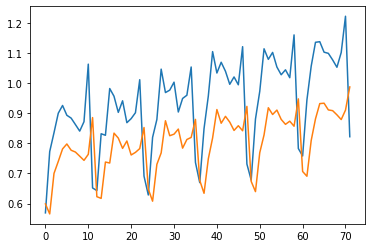

In [53]:
#Graficamos los "y" reales y los "y" predichos
plt.plot(y_test)
plt.plot(y_prediccion)

### Vemos que el modelo anterior la red se acerca mucho al modelo,**o sea aprendio el modelo pero no aprendió la tendencia**. **Sube y baja y se aleja de la realidad**.
### Por eso se debe usar la red recurrente.

In [ ]:
#Vamos a procesar esto con una red recurrente

# Almacenamiento de Features para una red recurrente en forma tensorial

In [54]:
#Verificamos las dimensiones de los features de entrenamiento y notamos que es un tensor de orden 1
x_train.shape

(239, 1)

In [56]:
#Es necesario convertirlo a un tensor de orden tres
#En la primera posición están la cantidad de registros que se procesan
#En la segunda, de cuánto en cuánto (temporalidad) se procesan, lo procesaremos de 1 en 1
#En el tercer, el número de features, en nuestro ejemplo 1 (monto de venta actual)
#Podemos convertirlo a un tensor de orden 3 de la siguiente manera
x_train_tensor = x_train[:, None] # Le agregamos una columna más
x_train_tensor.shape

(239, 1, 1)

In [57]:
#Hacemos lo mismo con los datos de validación
x_test_tensor = x_test[:, None]
x_test_tensor.shape

(72, 1, 1)

In [58]:
#Vamos a guardar los datos de entrenamiento en un archivo tensorial
dataset_train = {}
dataset_train['features'] = x_train_tensor
dataset_train['labels'] = y_train
dataset_train_numpy = np.array(dataset_train)

In [60]:
#Guardamos el archivo
np.savez('/content/drive/MyDrive/Data/train_rr', dataset_train_numpy)

In [61]:
#Hacemos lo mismo con la data de validación
dataset_test = {}
dataset_test['features'] = x_test_tensor
dataset_test['labels'] = y_test
dataset_test_numpy = np.array(dataset_test)

#Guardamos el archivo
np.savez('/content/drive/MyDrive/Data/test_rr', dataset_test_numpy)